Link to Github repository: https://github.com/fridamariejoergensen/CSS.git <br>
### Contribution Statement

We, Frida(s206182), Cecilie(s214605), and Marie(s204052), collaborated on Assignment 1 in Jupyter Notebook and made the following contributions:

- Cecilie focused on part 3 

- Frida focused on part 1 

- Marie did part 2 

But all members collaborated and contributed to multiple parts of the assignment.


# Assignment 1

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as img
import time
import pickle
import logging
import os
import math

## Part 1: Using web-scraping to gather data

### 2019 edition

In [2]:
## Poster presentations
LINK = "https://2019.ic2s2.org/posters/"
r = requests.get(LINK) 
soup = BeautifulSoup(r.content)

In [3]:
listul = soup.find("div",{"class":"col-md-8 page-content-wrap"})
listli = listul.find_all("li")

allnames = []
for i in range(len(listli)):
    if listli[i].find("strong"):
        listli[i].strong.extract()
    if listli[i].find("span"):
        listli[i].span.extract()
    if listli[i].find("br"):
        listli[i].br.extract()
        
    names = listli[i].text.replace("\n","").replace(" and ",",").replace(", ",",")
    allnames = allnames + names.split(",")
    

un2019 = np.unique(np.array(allnames))
len(un2019)

461

There was 461 unique researchers that made poster presentations in 2019  

In [4]:
#### Oral presentations
LINK = 'https://2019.ic2s2.org/oral-presentations/'
r = requests.get(LINK)
all_oral = BeautifulSoup(r.content)

In [5]:
# extract the specific element of the site that contains the names
paragraphs = all_oral.find_all("p", {"class":""})[3:39]

#loop over each p and split text at delimeters "-", "."
names = []
for p in paragraphs:
    text = p.text.strip()
    lines = text.split(' – ')
    names.extend([line.split('.')[0] for line in lines[1:]])

# Extract list elements that contain numbers.

def remove_elements_with_numbers(names):
    return [i for i in names if not any(j.isdigit() for j in i)]

p = remove_elements_with_numbers(names)

# Split by delimeter ',' and remove 'No presentation'
newlist = [word for line in p for word in line.split(',')]
newlist.remove('No Presentation')

# Find length of list with unique names
final_list = np.asarray(newlist)
print(len(np.unique(final_list)))

521


There was 521 unique researchers that made oral presentations in 2019  

In [6]:
# Combine the two lists of poster and oral presentators
combined_list = np.concatenate((final_list, un2019))
# Find the length of unique combined list that attended the conference in 2019 
print(len(np.unique(combined_list)))

953


In total there was 953 unique researchers you got in 2019

**Explain one or two decisions you took during the web-scraping exercise, for 2019 or any other year. Why did you take this choice? How might your decision impact the final number of authors?**


To access the names of the researchers that did oral presentations in 2019, we had to exploit the position of both HTML tags and delimiters, as the names and remaining text in the HTML setup of the oral presentation names was not as clearly separated as in the poster presentations’ HTML. 


We chose to use the find.all method to extract the specific p elements from HTML (paragraph 4-40) that contained names and loop through each p element. For each p, we extracted the text content, and decided the best way to access the names was to split the text using the " - " and “.” delimiters, and save the text in a list. This resulted in a list that included strings of all the names but also time strings and “no presentation” strings. 

 In order to get a list with only the names we simply removed the “no presentation” elements and then defined and applied a function that would remove all strings containing numbers. ‘

The function unfortunately also removed the strings indicating who was chairperson, example: '12:30 Chair: Robert West 11:00', as the string contains numbers. But we saw that all chair people also gave presentations. If there had been more data, it would have been a bigger project to assess this and we would modify the code to take the chair people into account, but as it did not impact the final number of authors in this case, we chose not to.
 


## Part 2: Getting data from the Semantic Scholar API
Consider the list of author ids you have found in Week 2, Part 3, first excercise. For each author, use the Academic Graph API to find: <br>
- their aliases <br>
- their name <br>
- their papers <br>

(**Share the number of authors you will use as starting point in this exercises. Add a comment clarifying how many IC2S2 editions you included and if the collaborators were included or not!!)

Create three dataframe to store the data you have collected:

**Author dataset**: in the author dataset, one raw is one unique author, and each row contains the following information: <br>
- authorId: (str) the id of the author <br>
- name: (str) the name of the author <br> 
- aliases: (list) the aliases of the author <br>
- citationCount: (int) the total number of citations received by an author <br>
- field: (str) the s2FieldsOfStudy that occurs most times across an author's papers (you should first obtain the category for each s2FieldsOfStudy) 



**Paper dataset**: in the paper dataset, one row is one unique paper, and each row contains the following information: <br>
- paperId: (str) the id of the paper <br>
- title: (str) the title of the paper <br> 
- year: (int) the year of publication <br>
- externalId.DOI: (str) the DOI of the paper <br>
- citationCount: (int) the number of citations <br>
- fields: (list) the fields included in the paper (you should first obtain the category for each s2FieldsOfStudy) <br>
-  authorIds: (list) this is a list of author Ids, including all the authors of this paper that are in our author dataset



**Paper abstract dataset**: in the paper abstract dataset, one row is one unique paper, and each row contains the following information: <br>
- paperId: (str) the id of the paper <br>
- abstract: (str) the abstract of the paper


In [7]:
#Open txt file for logging the events that happen when collecting all the data:
open('collectingData.log','a+')

logging.basicConfig(filename='collectingData.log', 
filemode='a',
level=logging.INFO, 
format='%(asctime)s | %(name)s | %(levelname)s | %(message)s')

We used names from the conferences in 2019, 2020 and 2021. In total, that gave us 122293 names. We attempted to collect data for each of theses in batches with the code below. Sometimes, authorIds return nothing (None) or gave server errors. Therefore, we delevoped a method to search out the faulty Ids, so we could obtain information from as many authors as possible.

In [8]:
# Code to load pickle with all names of comp sci people:
if os.path.isfile("pickles"+"/all_names"):
    with open("pickles/all_names","rb") as fp:
        all_names = pickle.load(fp)
else:
    #If you don't have the file, here are 5 random ids in a dict structure, since that is what we have used:
    all_names = {"5138378":1,"6568079":1,"31640297":1,"1398492717":1,"1405880203":1}
print("We have {} authors to search through.".format(len(all_names)))


We have 122293 authors to search through.


In [9]:
BASE_URL = "https://api.semanticscholar.org/graph/"
VERSION = "v1/"

author_url = BASE_URL + VERSION + "author/batch"

class compSciData:
    def __init__(self,authorIds,picklePath="pickles"):
        self.authorIds = authorIds
        logging.info("Length of author Id list: {}".format(len(authorIds)))
        self.authordf = pd.DataFrame(columns = ['authorId','name', 'aliases','citationCount','field'])
        self.paperdf = pd.DataFrame(columns = ['paperId','title', 'year','externalId.DOI','citationCount','fields','authorIds'])
        self.abstractdf = pd.DataFrame(columns = ['paperId','abstract'])    
        self.authordict= {}
        self.paperdict = {}
        self.abstractdict = {}
        self.checkedAuthors = {}
        self.faultyAuthors = {}
        self.picklePath = picklePath
        self.authorURL = BASE_URL + VERSION + "author/batch"
        

    def loadPickles(self):
        if os.path.isfile(self.picklePath+"/finalAuthorDf"):
            self.authordf = pickle.load( open(self.picklePath+"/finalAuthorDf", "rb" ) )
            #print("Opened pickle with author dataframe.")
            logging.info("Opened pickle with author dataframe.")

        if os.path.isfile(self.picklePath+"/finalPaperDf"):
            self.paperdf = pickle.load( open( self.picklePath+"/finalPaperDf", "rb" ) )
            #print("Opened pickle with paper dataframe.")
            logging.info("Opened pickle with paper dataframe.")

        if os.path.isfile(self.picklePath+"/finalAbstractDf"):
            self.abstractdf = pickle.load( open( self.picklePath+"/finalPaperDf", "rb" ) )
            #print("Opened pickle with abstract dataframe.")
            logging.info("Opened pickle with abstract dataframe.")

        if os.path.isfile(self.picklePath+"/checkedAuthors"):
            self.checkedAuthors = pickle.load( open( self.picklePath+"/checkedAuthors", "rb" ) )
            #print("Opened pickle with checked authors of length {}.".format(len(self.checkedAuthors)))
            logging.info("Opened pickle with checked authors of length {}.".format(len(self.checkedAuthors)))


    def handleRequests(self,cleanAuthBatch):
        #Send request for the given ids:
        params = {"ids":cleanAuthBatch,
                                "limit":10000}
        r = requests.post(self.authorURL+"?fields=aliases,name,papers,papers.title,papers.abstract,papers.citationCount,"
        +"papers.s2FieldsOfStudy,papers.year,papers.externalIds,papers.authors", json=params)
        data = r.json()
        
        # If data returns message, there is some error, which is likely either too many requests or an internal server error
        if type(data)==list:
            self.sortAuthorDataInDataframesDict(data,cleanAuthBatch)
            # Sleep three secs per request to not exceed 100 requests per 5 min.
            time.sleep(3)
        elif 'message' in data.keys():
            #print("Request returned a message: "+data['message'])
            logging.warning("Request returned a message: "+data['message'])
            if data['message']=='Internal server error' or data['message']=='Endpoint request timed out':
                # Sleep three secs per request to not exceed 100 requests per 5 min.
                time.sleep(3)
                self.findFaultyData(cleanAuthBatch)
            elif data['message']=='Too Many Requests':
                time.sleep(30)
                self.handleRequests(cleanAuthBatch)
            else: 
                #If some other error just pass to next clean batch after waiting a bit:
                time.sleep(30)
                pass

    def findFaultyData(self, cleanAuthBatch):
        batchLength = len(cleanAuthBatch)
        #print("Initiating search for faulty data with batchLength {}.".format(batchLength))
        logging.info("Initiating search for faulty data with batchLength {}.".format(batchLength))
        if batchLength>3:
            middleindex = batchLength//2
            halves = [cleanAuthBatch[:middleindex],cleanAuthBatch[middleindex:]]
            for half in halves:
                self.handleRequests(half)
        elif batchLength>1:
            halves = [[id] for id in cleanAuthBatch]
            for half in halves:
                self.handleRequests(half)
        else:
            #print("Faulty id: Found that author with id {} returns a server error upon request.".format(cleanAuthBatch))
            logging.warning("Faulty id: Found that author with id {} returns a server error upon request.".format(cleanAuthBatch))
            #Save in the checked authors list, so we don't check author again.
            self.checkedAuthors[cleanAuthBatch[0]]=1 
            self.faultyAuthors[cleanAuthBatch[0]]="error"          

    
    def sortAuthorDataInDataframesDict(self,data,cleanAuthBatch):
        # Takes data object containing the info returned from a request with authorIds. Sorts the data
        # into the dataframes contained in self.
        #print("Initiating sortAuthorDataInDataframesDict")
        logging.info("Initiating sortAuthorDataInDataframesDict")

        # Look at every author:
        for i in range(len(data)):
            # Only proceed if the request for current author did return something, aka didn't return None
            if data[i]:
                authorData = data[i]
                papers = authorData['papers']
                #initialize variables for later:
                fields = []
                citationCount = 0
                
                #Look at everyone of their papers:
                for n in range(len(papers)):
                    paper = papers[n]
                    paper_fields = []
                    for s2 in paper['s2FieldsOfStudy']:
                        paper_fields.append(s2['category'])
                    fields=fields+paper_fields
                    citationCount += paper['citationCount']

                    paper_authors = []
                    for auth in paper['authors']:
                        paper_authors.append(auth['authorId'])


                    self.paperdict[paper['paperId']] = {'paperId':paper['paperId'],'title':paper['title'], 'year':paper['year'],
                    'externalId.DOI': paper['externalIds'].get('DOI'),'citationCount':paper['citationCount'],'fields':[paper_fields],
                    'authorIds':[paper_authors]}

                    self.abstractdict[paper['paperId']] = {'paperId':paper['paperId'],'abstract':paper['abstract']}

                self.authordict[authorData['authorId']] = {'authorId' : authorData['authorId'], 'name' : authorData['name'], 
                'aliases' : [authorData['aliases']],'citationCount':citationCount,'field': max(fields,key=fields.count) if fields else None}

                # Add authorId to dict with checked authors:
                self.checkedAuthors[authorData['authorId']]=1

            else:
                #print("Author with id {} returned a Nonetype object.".format(cleanAuthBatch[i]))
                logging.info("Author with id {} returned a Nonetype object.".format(cleanAuthBatch[i]))
                self.checkedAuthors[cleanAuthBatch[i]]=1
                self.faultyAuthors[cleanAuthBatch[i]]="none"


    def findData(self, batchsize=100):
        # Avoid batchsize errors:
        if batchsize>100:
            #print("Batchsize can maximum be 100 because we are requesting fields=papers attributes.")
            logging.error("Batchsize can maximum be 100 because we are requesting fields=papers attributes.")
            return
        
        # Find papers for every name:
        batches = math.floor(len(self.authorIds)/batchsize)
        for k in range(batches+1):
            #Calculate indexes for next batch:
            lowerbound = k*batchsize
            if k == batches:
                upperbound = lowerbound+len(self.authorIds)%batchsize
            else:
                upperbound = lowerbound+batchsize
            
            #Remove all authors that have already been checked:
            authBatch = self.authorIds[lowerbound:upperbound]
            cleanAuthBatch = []
            for id in authBatch:
                if id not in self.checkedAuthors:
                    cleanAuthBatch.append(id)

            #Only proceed if there are still authors left after cleaning
            if len(cleanAuthBatch)>0:
                
                # Takes authorIds that have not yet been used and handles the request, errorhandling and puts data in 
                # to dataframes in helper functions:
                self.handleRequests(cleanAuthBatch)

                print("Code has processed {} names.".format(upperbound))
                logging.info("Code has processed {} names.".format(upperbound))

                #Save pickles during process as a back up.
                if upperbound%5000==0:
                    self.savePickles(path="pickles/{}".format(upperbound))

    
    def savePickles(self, path="pickles"):
        #Concatenate dataframe so far with the recently collected dicts:
        self.authordf = pd.concat([self.authordf,pd.DataFrame.from_dict(self.authordict,"index")], ignore_index=True)
        self.paperdf = pd.concat([self.paperdf,pd.DataFrame.from_dict(self.paperdict,"index")], ignore_index=True)
        self.abstractdf = pd.concat([self.abstractdf,pd.DataFrame.from_dict(self.abstractdict,"index")], ignore_index=True)

        #Clear dicts, so we don't save them into the dataframe twice:
        self.authordict={}
        self.paperdict={}
        self.abstractdict={}

        #Create folder if it does not exist:
        if not os.path.exists(path):
            os.makedirs(path)

        # Save the pickles:
        pickle.dump(self.authordf,open("{}/finalAuthorDf".format(path),"wb"))
        pickle.dump(self.paperdf,open("{}/finalPaperDf".format(path),"wb"))
        pickle.dump(self.abstractdf,open("{}/finalAbstractDf".format(path),"wb"))
        pickle.dump(self.checkedAuthors,open("{}/checkedAuthors".format(path),"wb"))
        print("Pickles saved succesfully to path {}!".format(path))
        logging.info("Pickles saved succesfully to path {}!".format(path))

In [10]:
# Call the class above and start creating dataframes with the comp sci names.
# Currently just inputting 100 names. In our actual runs, we slowly included all the names.
inputNo = 100

maxIndex = min(len(list(all_names.keys())),inputNo)
data = compSciData(authorIds=list(all_names.keys())[:maxIndex],picklePath ="pickles")
data.loadPickles()
data.findData(batchsize=100)
data.savePickles()

logging.info("There were {} faulty authorIds, which were:".format(len(data.faultyAuthors)))
logging.info(data.faultyAuthors)

logging.info("The author dataframe has length:".format(len(data.authordf)))
logging.info("The paper dataframe has length:".format(len(data.paperdf)))

Code has processed 100 names.
Pickles saved succesfully to path pickles!


How long is your final Author dataframe? How long is your final Paper dataframe?

We ran the code above on the DTU HPC to relieve our own computers. We ended up with an author dataframe of 120,516 authors. Our paper dataframe contained 7,463,239 papers. 

## Part 3: Law of large numbers.

In [11]:
# 1. Sampling points from Gaussian distribution with mean = 0 and std = 4
N = 10000
mu = 0
sigma = 4

X = np.random.normal(mu, sigma, N)

-15.884911795107083 16.388712105617238


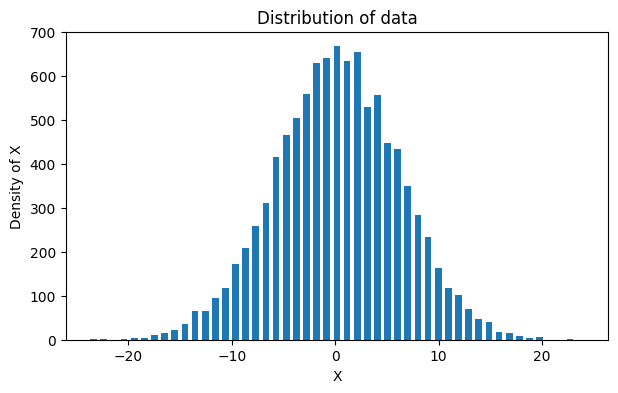

In [12]:
# 2. Plotting the distribution of data in a histogram
print(min(X), max(X))
bins = np.linspace(-16, 16, 50)
hist, edges = np.histogram(X, bins=bins)
x = edges[1:]+edges[:-1]/2
width = bins[1]-bins[0]
fig, ax = plt.subplots(figsize=(7,4))
ax.bar(x, hist, width)
ax.set_ylabel('Density of X')
ax.set_xlabel('X')
ax.set_title('Distribution of data')

# Save the plot as PNG file
plt.savefig('distribution.png')

Text(0.5, 0.98, 'Distribution of random sampled data X')

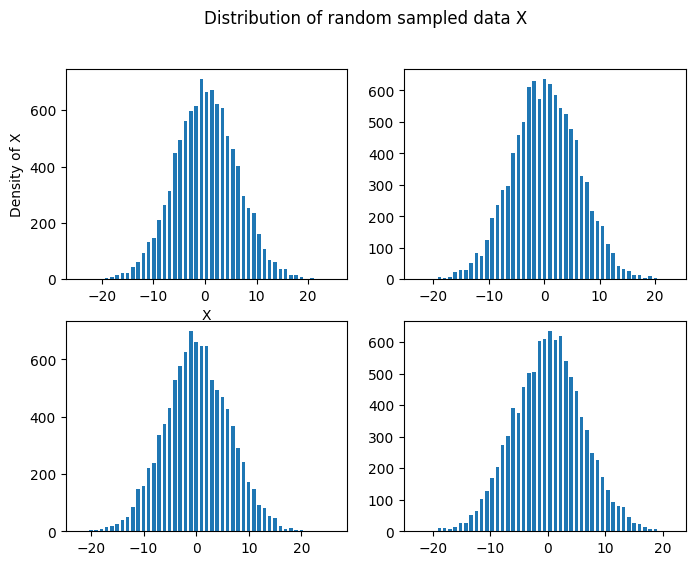

In [13]:
# Plotting the distribution for 4 random samples from the Gaussian distribution
X1 = np.random.normal(mu, sigma, N)
X2 = np.random.normal(mu, sigma, N)
X3 = np.random.normal(mu, sigma, N)
X4 = np.random.normal(mu, sigma, N)

# Plotting the distribution of data in a histogram
fig, ax = plt.subplots(2, 2, figsize=(8,6))

bins1 = np.linspace(min(X1), max(X1), 50)
hist1, edges1 = np.histogram(X1, bins=bins1)
x1 = edges1[1:]+edges1[:-1]/2
width1 = bins1[1]-bins1[0]
ax[0,0].bar(x1, hist1, width1)
ax[0,0].set_ylabel('Density of X')
ax[0,0].set_xlabel('X')

bins2 = np.linspace(min(X2), max(X2), 50)
hist2, edges2 = np.histogram(X2, bins=bins2)
x2 = edges2[1:]+edges2[:-1]/2
width2 = bins2[1]-bins2[0]
ax[0,1].bar(x2, hist2, width2)

bins3 = np.linspace(min(X3), max(X3), 50)
hist3, edges3 = np.histogram(X3, bins=bins3)
x3 = edges3[1:]+edges3[:-1]/2
width3 = bins3[1]-bins3[0]
ax[1,0].bar(x3, hist3, width3)

bins4 = np.linspace(min(X4), max(X4), 50)
hist4, edges4 = np.histogram(X4, bins=bins4)
x4 = edges4[1:]+edges4[:-1]/2
width4 = bins4[1]-bins4[0]
ax[1,1].bar(x4, hist4, width4)

fig.suptitle('Distribution of random sampled data X')

In [14]:
# 3. Cumulative average of X
cum_av = np.array([])
for i in range(1, N+1):
    val = X[0:i]
    cum_av = np.append(cum_av, np.mean(val))
    
print(cum_av)

[-3.83792544 -2.5369435  -0.70999865 ...  0.0459003   0.04618923
  0.04620496]


In [15]:
# 4. Cumulative std of X
cum_std = np.array([])
for i in range(1, N+1):
    val = X[0:i]
    cum_std = np.append(cum_std, np.std(val)/np.sqrt(N))
    
print(cum_std)

[0.         0.01300982 0.02793533 ... 0.04004657 0.04004561 0.04004361]


In [16]:
# 5. Computing distribution mean and median from Wikipedia formulas
mean = 1/N * sum(X)

X_new = np.copy(X)
X_new = np.sort(X_new)
median = (X_new[int(N/2)] + X_new[int((N/2+1))])/2

print(mean, median)

0.04620495556777022 0.046369116589514224


C:\Users\marie\AppData\Local\Temp\ipykernel_17888\3842886459.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


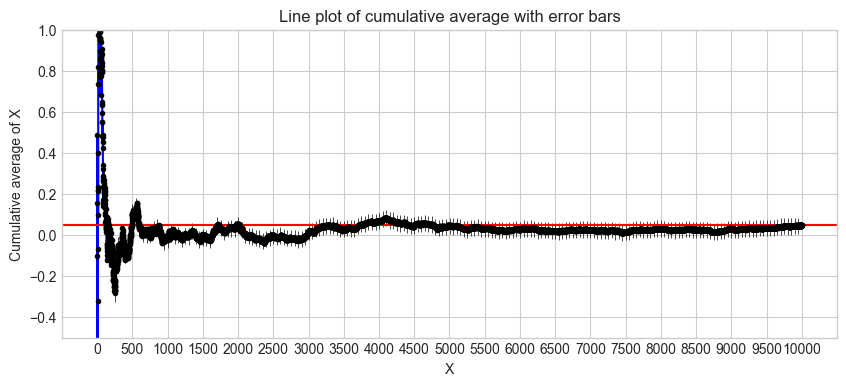

In [17]:
# 6. Line plot of cumulative average with error bars and horizontal line of distribution mean
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(10,4))
plt.plot(range(N), cum_av, c = 'blue')
plt.errorbar(range(N), cum_av, yerr = cum_std, fmt='.k', errorevery=(1, 50), elinewidth=0.5)
plt.axhline(mean, c = 'red')
plt.xticks(np.arange(0,10100,step=500))
plt.ylim(-0.5,1)
plt.ylabel('Cumulative average of X')
plt.xlabel('X')
plt.title('Line plot of cumulative average with error bars')

# Save the plot as a PNG file
plt.savefig('cumulative_average_with_error_bars.png', dpi=300)

C:\Users\marie\AppData\Local\Temp\ipykernel_17888\3806671911.py:67: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


(-2.0, 2.0)

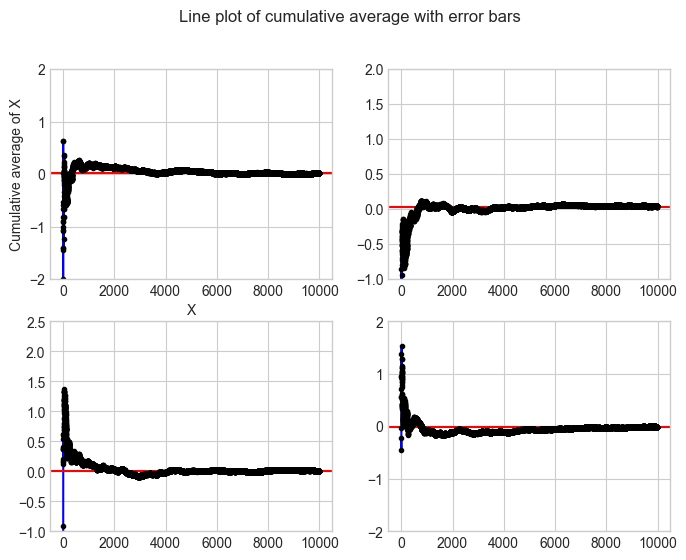

In [18]:
# For the 4 random samples from the Gaussian distribution
# Computing cumulative average of X
cum_av1 = np.array([])
for i in range(1, N+1):
    val = X1[0:i]
    cum_av1 = np.append(cum_av1, np.mean(val))

cum_av2 = np.array([])
for i in range(1, N+1):
    val = X2[0:i]
    cum_av2 = np.append(cum_av2, np.mean(val))

cum_av3 = np.array([])
for i in range(1, N+1):
    val = X3[0:i]
    cum_av3 = np.append(cum_av3, np.mean(val))

cum_av4 = np.array([])
for i in range(1, N+1):
    val = X4[0:i]
    cum_av4 = np.append(cum_av4, np.mean(val))

# Computing cumulative std of X
cum_std1 = np.array([])
for i in range(1, N+1):
    val = X1[0:i]
    cum_std1 = np.append(cum_std1, np.std(val)/np.sqrt(N))

cum_std2 = np.array([])
for i in range(1, N+1):
    val = X2[0:i]
    cum_std2 = np.append(cum_std2, np.std(val)/np.sqrt(N))

cum_std3 = np.array([])
for i in range(1, N+1):
    val = X3[0:i]
    cum_std3 = np.append(cum_std3, np.std(val)/np.sqrt(N))

cum_std4 = np.array([])
for i in range(1, N+1):
    val = X4[0:i]
    cum_std4 = np.append(cum_std4, np.std(val)/np.sqrt(N))

# Computing distribution mean and median (from Wiki formulas)
mean1 = 1/N * sum(X1)
mean2 = 1/N * sum(X2)
mean3 = 1/N * sum(X3)
mean4 = 1/N * sum(X4)

X1_new = np.copy(X1)
X1_new = np.sort(X1_new)
median1 = (X1_new[int(N/2)] + X1_new[int((N/2+1))])/2

X2_new = np.copy(X2)
X2_new = np.sort(X2_new)
median2 = (X2_new[int(N/2)] + X2_new[int((N/2+1))])/2

X3_new = np.copy(X3)
X3_new = np.sort(X3_new)
median3 = (X3_new[int(N/2)] + X3_new[int((N/2+1))])/2

X4_new = np.copy(X4)
X4_new = np.sort(X4_new)
median4 = (X4_new[int(N/2)] + X4_new[int((N/2+1))])/2

# Plot of cumulative average as line plot with error bars and horizontal line of distribution mean
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(2, 2, figsize=(8,6))

ax[0,0].plot(range(N), cum_av1, c = 'blue')
ax[0,0].errorbar(range(N), cum_av1, yerr = cum_std1, fmt='.k', errorevery=(1, 100))
ax[0,0].axhline(mean1, c = 'red')
ax[0,0].set_ylim(-2,2)
ax[0,0].set_ylabel('Cumulative average of X')
ax[0,0].set_xlabel('X')
fig.suptitle('Line plot of cumulative average with error bars')

ax[0,1].plot(range(N), cum_av2, c = 'blue')
ax[0,1].errorbar(range(N), cum_av2, yerr = cum_std2, fmt='.k', errorevery=(1, 100))
ax[0,1].axhline(mean2, c = 'red')
ax[0,1].set_ylim(-1,2)

ax[1,0].plot(range(N), cum_av3, c = 'blue')
ax[1,0].errorbar(range(N), cum_av3, yerr = cum_std3, fmt='.k', errorevery=(1, 100))
ax[1,0].axhline(mean3, c = 'red')
ax[1,0].set_ylim(-1,2.5)

ax[1,1].plot(range(N), cum_av4, c = 'blue')
ax[1,1].errorbar(range(N), cum_av4, yerr = cum_std4, fmt='.k', errorevery=(1, 100))
ax[1,1].axhline(mean4, c = 'red')
ax[1,1].set_ylim(-2,2)

In [19]:
# 7. Cumulative median of X
cum_median = np.array([])
for i in range(1, N+1):
    val = X[0:i]
    cum_median = np.append(cum_median, np.median(val))
    
print(cum_median)

[-3.83792544 -2.5369435  -1.23596157 ...  0.04535205  0.04547
  0.04574279]


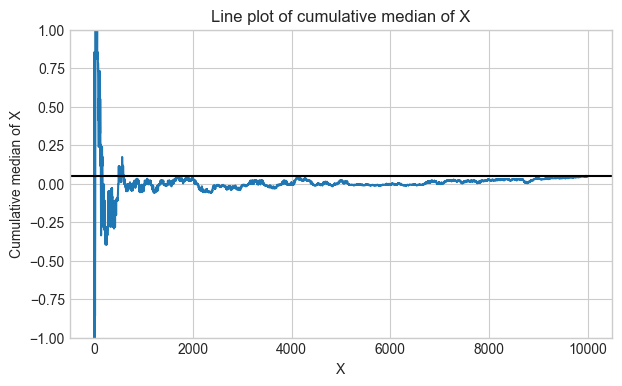

In [20]:
# 8. Line plot of cumulative median and horizontal line of distribution median
plt.figure(figsize=(7,4))
plt.plot(range(N), cum_median)
plt.axhline(median, c = 'black')
plt.title('Line plot of cumulative median of X')
plt.xlabel('X')
plt.ylabel('Cumulative median of X')
plt.ylim(-1,1)

# Save the plot as a PNG file
plt.savefig('cumulative_median.png')

(-1.5, 2.0)

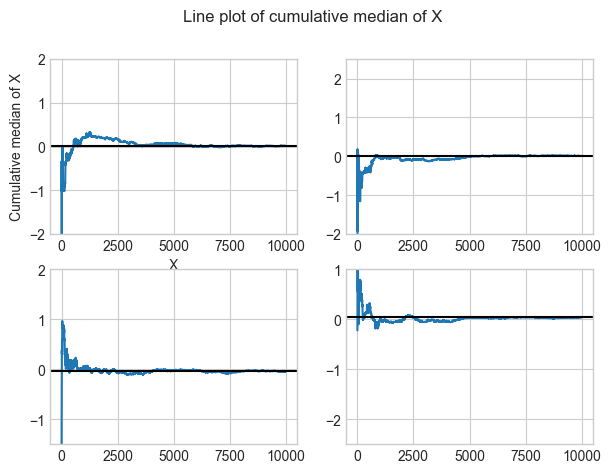

In [21]:
# For the 4 random samples from the Gaussian distribution
# Cumulative median of X
cum_median1 = np.array([])
for i in range(1, N+1):
    val = X1[0:i]
    cum_median1 = np.append(cum_median1, np.median(val))

cum_median2 = np.array([])
for i in range(1, N+1):
    val = X2[0:i]
    cum_median2 = np.append(cum_median2, np.median(val))
    
cum_median3 = np.array([])
for i in range(1, N+1):
    val = X3[0:i]
    cum_median3 = np.append(cum_median3, np.median(val))
    
cum_median4 = np.array([])
for i in range(1, N+1):
    val = X4[0:i]
    cum_median4 = np.append(cum_median4, np.median(val))

# Plot of cumulative median and horizontal line of distribution median
fig, ax = plt.subplots(2,2, figsize=(7,5))
fig.suptitle('Line plot of cumulative median of X')

ax[0,0].plot(range(N), cum_median1)
ax[0,0].axhline(median1, c = 'black')
ax[0,0].set_xlabel('X')
ax[0,0].set_ylabel('Cumulative median of X')
ax[0,0].set_ylim(-2,2)

ax[0,1].plot(range(N), cum_median2)
ax[0,1].axhline(median2, c = 'black')
ax[0,1].set_ylim(-2,2.5)

ax[1,1].plot(range(N), cum_median4)
ax[1,1].axhline(median4, c = 'black')
ax[1,1].set_ylim(-2.5,1)

ax[1,0].plot(range(N), cum_median3)
ax[1,0].axhline(median3, c = 'black')
ax[1,0].set_ylim(-1.5,2)

In [22]:
# 9. Sampling from Pareto distribution with x_m = 1 and alpha = 0.5
N = 10000
x_m = 1
alpha = 0.5

Data = np.random.pareto(alpha, N)

In [23]:
# 10.2 Plotting distribution of Pareto data


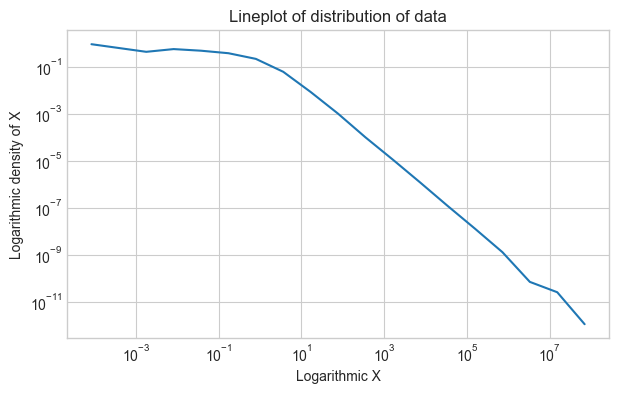

In [24]:
# 10.2 Plotting distribution of Pareto data with logarithmic scale
bins = np.logspace(np.log10(min(Data)), np.log10(max(Data)), 20)
hist, edges = np.histogram(Data, bins=bins, density=True)
x = (edges[1:]+edges[:-1])/2
# removing empty bins
xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(xx, yy, width)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Lineplot of distribution of data')
ax.set_ylabel('Logarithmic density of X')
ax.set_xlabel('Logarithmic X')

# Save the plot as PNG file
plt.savefig('cumulative_average_plot.png', dpi=300, bbox_inches='tight')

Text(0.5, 0.98, 'Lineplot of distribution of data')

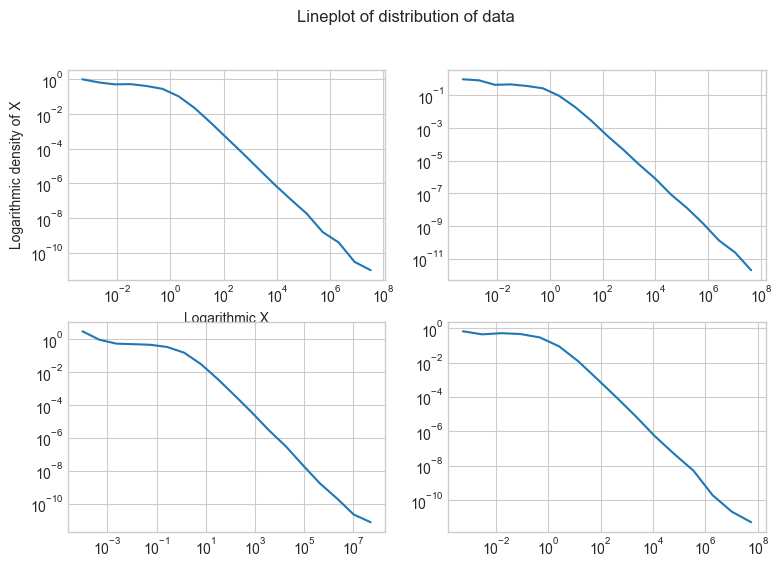

In [25]:
# For the 4 random samples from the Pareto distribution
Data1 = np.random.pareto(alpha, N)
Data2 = np.random.pareto(alpha, N)
Data3 = np.random.pareto(alpha, N)
Data4 = np.random.pareto(alpha, N)

fig, ax = plt.subplots(2,2, figsize=(9,6))

bins1 = np.logspace(np.log10(min(Data1)), np.log10(max(Data1)), 20)
hist1, edges1 = np.histogram(Data1, bins=bins1, density=True)
x1 = (edges1[1:]+edges1[:-1])/2
# removing empty bins
xx1, yy1 = zip(*[(i,j) for (i,j) in zip(x1, hist1) if j>0])
width1 = bins1[1]-bins1[0]
ax[0,0].plot(xx1, yy1, width1)
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Logarithmic density of X')
ax[0,0].set_xlabel('Logarithmic X')

bins2 = np.logspace(np.log10(min(Data2)), np.log10(max(Data2)), 20)
hist2, edges2 = np.histogram(Data2, bins=bins2, density=True)
x2 = (edges2[1:]+edges2[:-1])/2
# removing empty bins
xx2, yy2 = zip(*[(i,j) for (i,j) in zip(x2, hist2) if j>0])
width2 = bins2[1]-bins2[0]
ax[0,1].plot(xx2, yy2, width2)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')

bins3 = np.logspace(np.log10(min(Data3)), np.log10(max(Data3)), 20)
hist3, edges3 = np.histogram(Data3, bins=bins3, density=True)
x3 = (edges3[1:]+edges3[:-1])/2
# removing empty bins
xx3, yy3 = zip(*[(i,j) for (i,j) in zip(x3, hist3) if j>0])
width3 = bins2[1]-bins2[0]
ax[1,0].plot(xx3, yy3, width3)
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')

bins4 = np.logspace(np.log10(min(Data4)), np.log10(max(Data4)), 20)
hist4, edges4 = np.histogram(Data4, bins=bins4, density=True)
x4 = (edges4[1:]+edges4[:-1])/2
# removing empty bins
xx4, yy4 = zip(*[(i,j) for (i,j) in zip(x4, hist4) if j>0])
width4 = bins4[1]-bins4[0]
ax[1,1].plot(xx4, yy4, width4)
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')

fig.suptitle('Lineplot of distribution of data')

In [26]:
# 10.3 Computing cumulative average of X
cum_av = np.array([])
for i in range(1, N+1):
    val = Data[0:i]
    cum_av = np.append(cum_av, np.mean(val))
    
print(cum_av)

# 10.4 Computing cumulative std of X
cum_std = np.array([])
for i in range(1, N+1):
    val = Data[0:i]
    cum_std = np.append(cum_std, np.std(val)/np.sqrt(N))
    
print(cum_std)

# 10.5 Computing distribution mean and median from Wikipedia formulas
mean = 1/N * sum(Data)
Data_new = np.copy(Data)
Data_new = np.sort(Data_new)
median = (Data_new[int(N/2)] + Data_new[int((N/2)+1)])/2
print(mean, median)

[1.46322862e+00 1.56403601e+00 1.32079045e+00 ... 2.87362691e+04
 2.87333962e+04 2.87305229e+04]
[0.00000000e+00 1.00807386e-03 3.53711119e-03 ... 1.55266515e+04
 1.55258753e+04 1.55250992e+04]
28730.522874126167 2.975301429839952


Text(0.5, 1.0, 'Line plot of cumulative average with error bars')

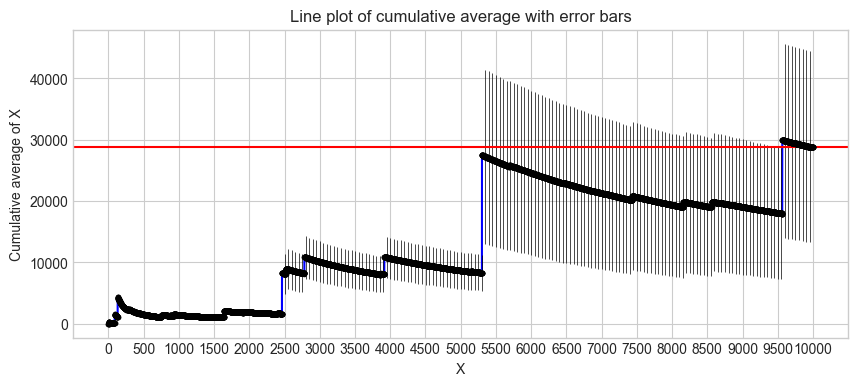

In [27]:
# 10.6 Line plot of cumulative average with error bars and horizontal line of distribution mean
plt.figure(figsize=(10,4))
plt.plot(range(N), cum_av, c = 'blue')
plt.errorbar(range(N), cum_av, yerr = cum_std, fmt='.k', errorevery=(1, 50), elinewidth=0.5)
plt.axhline(mean, c = 'red')

plt.xticks(np.arange(0,10100,step=500))
#plt.ylim(-1.5,1)
plt.ylabel('Cumulative average of X')
plt.xlabel('X')
plt.title('Line plot of cumulative average with error bars')

# Save the plot as PNG file



Text(0.5, 0.98, 'Line plot of cumulative average with error bars')

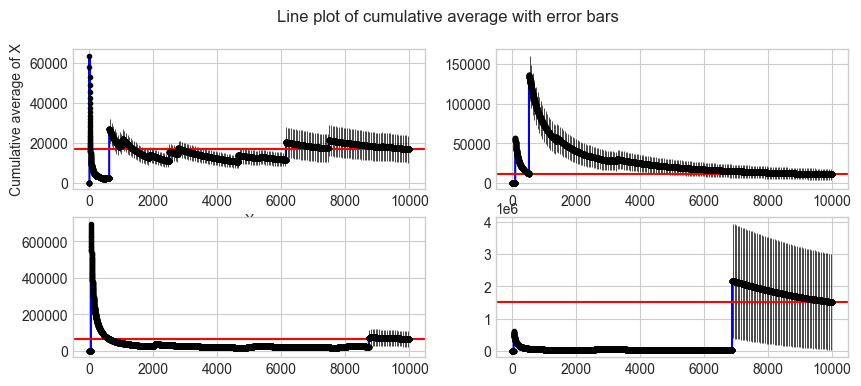

In [28]:
# For the 4 random samples from the Pareto distribution
# Computing cumulative average of X
cum_av1 = np.array([])
for i in range(1, N+1):
    val = Data1[0:i]
    cum_av1 = np.append(cum_av1, np.mean(val))

cum_av2 = np.array([])
for i in range(1, N+1):
    val = Data2[0:i]
    cum_av2 = np.append(cum_av2, np.mean(val))
    
cum_av3 = np.array([])
for i in range(1, N+1):
    val = Data3[0:i]
    cum_av3 = np.append(cum_av3, np.mean(val))

cum_av4 = np.array([])
for i in range(1, N+1):
    val = Data4[0:i]
    cum_av4 = np.append(cum_av4, np.mean(val))

# Computing cumulative std of X
cum_std1 = np.array([])
for i in range(1, N+1):
    val = Data1[0:i]
    cum_std1 = np.append(cum_std1, np.std(val)/np.sqrt(N))

cum_std2 = np.array([])
for i in range(1, N+1):
    val = Data2[0:i]
    cum_std2 = np.append(cum_std2, np.std(val)/np.sqrt(N))

cum_std3 = np.array([])
for i in range(1, N+1):
    val = Data3[0:i]
    cum_std3 = np.append(cum_std3, np.std(val)/np.sqrt(N))

cum_std4 = np.array([])
for i in range(1, N+1):
    val = Data4[0:i]
    cum_std4 = np.append(cum_std4, np.std(val)/np.sqrt(N))

# Computing distribution mean and median (from Wiki formulas)
mean1 = 1/N * sum(Data1)
mean2 = 1/N * sum(Data2)
mean3 = 1/N * sum(Data3)
mean4 = 1/N * sum(Data4)

Data_new1 = np.copy(Data1)
Data_new1 = np.sort(Data_new1)
median1 = (Data_new1[int(N/2)] + Data_new1[int((N/2)+1)])/2

Data_new2 = np.copy(Data2)
Data_new2 = np.sort(Data_new2)
median2 = (Data_new2[int(N/2)] + Data_new2[int((N/2)+1)])/2

Data_new3 = np.copy(Data3)
Data_new3 = np.sort(Data_new3)
median3 = (Data_new3[int(N/2)] + Data_new3[int((N/2)+1)])/2

Data_new4 = np.copy(Data4)
Data_new4 = np.sort(Data_new4)
median4 = (Data_new4[int(N/2)] + Data_new4[int((N/2)+1)])/2

# Plot of cumulative average as line plot with error bars and horizontal line of distribution mean

fig, ax = plt.subplots(2,2, figsize=(10,4))

ax[0,0].plot(range(N), cum_av1, c = 'blue')
ax[0,0].errorbar(range(N), cum_av1, yerr = cum_std1, fmt='.k', elinewidth=0.5, errorevery=(1,50))
ax[0,0].axhline(mean1, c = 'red')
#ax[0,0].xticks(np.arange(0,10100,step=500))
ax[0,0].set_ylabel('Cumulative average of X')
ax[0,0].set_xlabel('X')

ax[0,1].plot(range(N), cum_av2, c = 'blue')
ax[0,1].errorbar(range(N), cum_av2, yerr = cum_std2, fmt='.k', elinewidth=0.5, errorevery=(1,50))
ax[0,1].axhline(mean2, c = 'red')

ax[1,0].plot(range(N), cum_av3, c = 'blue')
ax[1,0].errorbar(range(N), cum_av3, yerr = cum_std3, fmt='.k', elinewidth=0.5, errorevery=(1,50))
ax[1,0].axhline(mean3, c = 'red')

ax[1,1].plot(range(N), cum_av4, c = 'blue')
ax[1,1].errorbar(range(N), cum_av4, yerr = cum_std4, fmt='.k', elinewidth=0.5, errorevery=(1,50))
ax[1,1].axhline(mean4, c = 'red')


fig.suptitle('Line plot of cumulative average with error bars')

[1.46322862 1.56403601 1.46322862 ... 2.9741775  2.97470992 2.9741775 ]


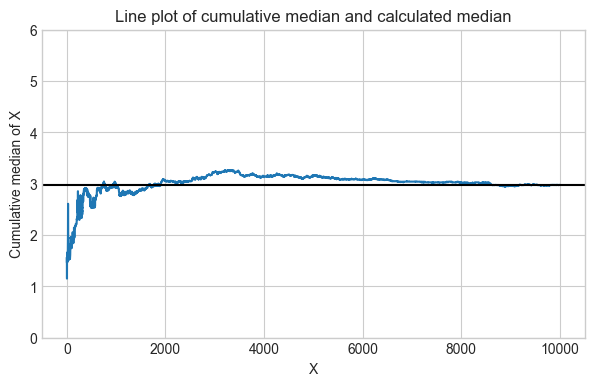

In [29]:
# 10.7 Cumulative median of X
cum_median = np.array([])
for i in range(1, N+1):
    val = Data[0:i]
    cum_median = np.append(cum_median, np.median(val))
    
print(cum_median)

# 9.8 Plot of cumulative median and horizontal line of distribution median
plt.figure(figsize=(7,4))
plt.plot(range(N), cum_median)
plt.axhline(median, c = 'black')
plt.ylim(0,6)
plt.xlabel('X')
plt.ylabel('Cumulative median of X')
plt.title('Line plot of cumulative median and calculated median')

# Save the plot as PNG file
plt.savefig('cumulative_median.png')

(0.0, 7.0)

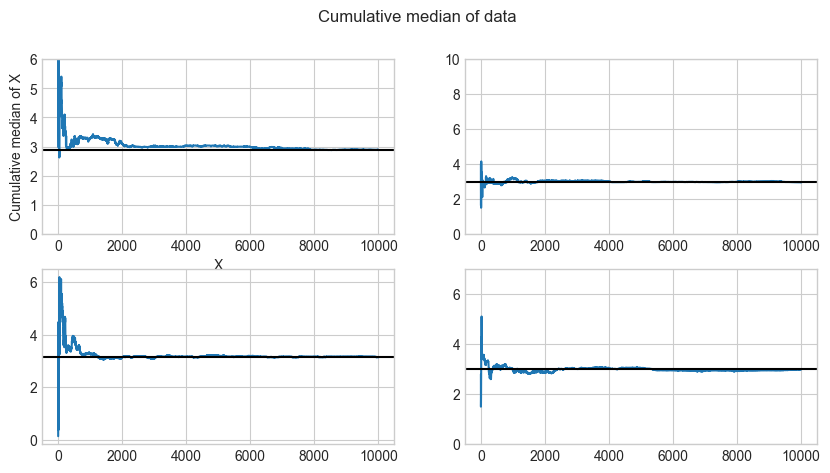

In [30]:
# For the 4 random samples from the Pareto distribution
cum_median1 = np.array([])
for i in range(1, N+1):
    val = Data1[0:i]
    cum_median1 = np.append(cum_median1, np.median(val))
    
cum_median2 = np.array([])
for i in range(1, N+1):
    val = Data2[0:i]
    cum_median2 = np.append(cum_median2, np.median(val))

cum_median3= np.array([])
for i in range(1, N+1):
    val = Data3[0:i]
    cum_median3 = np.append(cum_median3, np.median(val))

cum_median4 = np.array([])
for i in range(1, N+1):
    val = Data4[0:i]
    cum_median4 = np.append(cum_median4, np.median(val))

# Plot of cumulative median and horizontal line of distribution median
fig, ax = plt.subplots(2,2, figsize=(10,5))
fig.suptitle('Cumulative median of data')

ax[0,0].plot(range(N), cum_median1)
ax[0,0].axhline(median1, c = 'black')
ax[0,0].set_xlabel('X')
ax[0,0].set_ylabel('Cumulative median of X')
ax[0,0].set_ylim(0,6)

ax[1,0].plot(range(N), cum_median2)
ax[1,0].axhline(median2, c = 'black')

ax[0,1].plot(range(N), cum_median3)
ax[0,1].axhline(median3, c = 'black')
ax[0,1].set_ylim(0,10)

ax[1,1].plot(range(N), cum_median4)
ax[1,1].axhline(median4, c = 'black')
ax[1,1].set_ylim(0,7)

In [31]:
# Sampling from LogNormal distribution
N = 10000
mu = 0
sigma = 4

# Sampling 4 random samples from the distribution
data1 = np.random.lognormal(mu, sigma, N)
data2 = np.random.lognormal(mu, sigma, N)
data3 = np.random.lognormal(mu, sigma, N)
data4 = np.random.lognormal(mu, sigma, N)

5.058320079246991e-08 1829491.4368403463
2.9288527247917006e-07 59002107.201949775
6.246544787947729e-07 123280187.46613126
2.0657082749586713e-07 1119302.8598339632


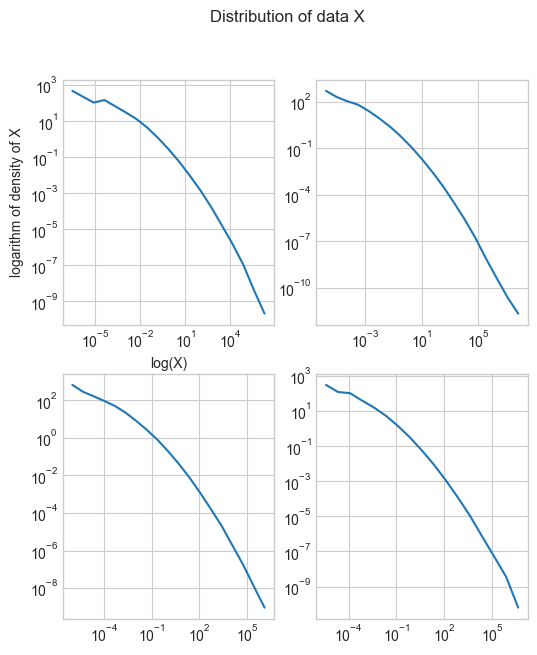

<Figure size 640x480 with 0 Axes>

In [32]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,7))
fig.suptitle('Distribution of data X')

# Plot data1
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0,0].set_xlabel('log(X)')
axs[0,0].set_ylabel('logarithm of density of X')
print(min(data1), max(data1))
bins = np.logspace(np.log10(min(data1)), np.log10(max(data1)), 20)
hist, edges = np.histogram(data1, bins=bins, density=True)
x = edges[1:]+edges[:-1]/2
xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]
axs[0, 0].plot(xx, yy)

# Plot data2
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
print(min(data2), max(data2))
bins = np.logspace(np.log10(min(data2)), np.log10(max(data2)), 20)
hist, edges = np.histogram(data2, bins=bins, density=True)
x = edges[1:]+edges[:-1]/2
xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]
axs[0, 1].plot(xx, yy)

# Plot data3
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
print(min(data3), max(data3))
bins = np.logspace(np.log10(min(data3)), np.log10(max(data3)), 20)
hist, edges = np.histogram(data3, bins=bins, density=True)
x = edges[1:]+edges[:-1]/2
xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]
axs[1, 1].plot(xx, yy)

# Plot data4
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
print(min(data4), max(data4))
bins = np.logspace(np.log10(min(data4)), np.log10(max(data4)), 20)
hist, edges = np.histogram(data4, bins=bins, density=True)
x = edges[1:]+edges[:-1]/2
xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]
axs[1, 0].plot(xx, yy)


plt.show()

# Save the plot as PNG file
plt.savefig('distribution_of_data_X.png')

In [51]:
# Data 1
#Function to calculate many useful stuff like cumulative average, cumulative std, mean and median:
def cumAvg(sample):
    cum_av = np.array([])
    cum_std = np.array([])
    for i in range(1, N+1):
        val = sample[0:i]

        # Computing cumulative average of X
        cum_av = np.append(cum_av, np.mean(val))

        # Computing cumulative std of X
        cum_std = np.append(cum_std, np.std(val)/np.sqrt(N))

    # Computing distribution mean and median (from Wiki formulas)
    mean = 1/N * sum(sample)
    sample_new = np.sort(np.copy(sample))
    median = (sample_new[int(N/2)] + sample_new[int((N/2)+1)])/2
    print("cummulative average: ",cum_av1)
    print("cummulative std: ",cum_std1)
    print("mean: ",mean)
    print("median: ",median)
    return cum_av,cum_std,mean,median

cum_av1,cum_std1,mean1,median1 = cumAvg(sample1)
cum_av2,cum_std2,mean2,median2 = cumAvg(sample2)
cum_av3,cum_std3,mean3,median3 = cumAvg(sample3)
cum_av4,cum_std4,mean4,median4 = cumAvg(sample4)



cummulative average:  [0.         0.         0.         ... 9.59311862 9.59215922 9.5917    ]
cummulative std:  [0.         0.         0.         ... 0.49203151 0.49200784 0.49198345]
mean:  9.591700000000001
median:  0.0
cummulative average:  [0.         0.         0.         ... 9.59311862 9.59215922 9.5917    ]
cummulative std:  [0.         0.         0.         ... 0.49203151 0.49200784 0.49198345]
mean:  10.539
median:  0.0
cummulative average:  [0.         0.         0.         ... 9.59311862 9.59215922 9.5917    ]
cummulative std:  [0.         0.         0.         ... 0.49203151 0.49200784 0.49198345]
mean:  9.683200000000001
median:  0.0
cummulative average:  [0.         0.         0.         ... 9.59311862 9.59215922 9.5917    ]
cummulative std:  [0.         0.         0.         ... 0.49203151 0.49200784 0.49198345]
mean:  10.772400000000001
median:  0.0


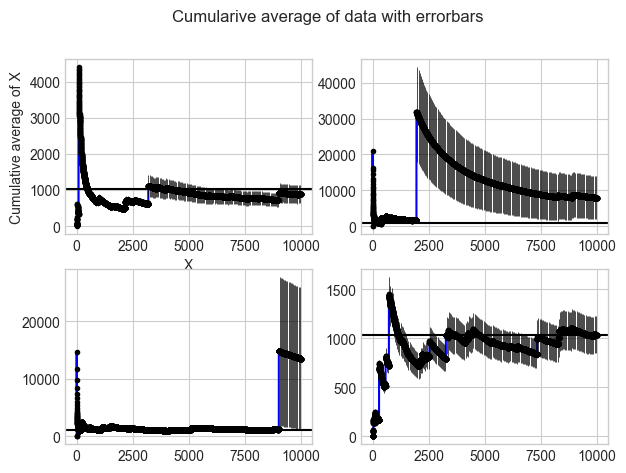

In [34]:
# 12.6 Plot of cumulative average as line plot with error bars and horizontal line of distribution mean
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7,5))
fig.suptitle('Cumularive average of data with errorbars')

axs[0, 0].plot(range(N), cum_av1, c='blue')
axs[0, 0].errorbar(range(N), cum_av1, yerr=cum_std1, fmt='.k', elinewidth=0.5, errorevery=(1,50))
axs[0, 0].axhline(mean, c='black')
axs[0,0].set_xlabel('X')
axs[0,0].set_ylabel('Cumulative average of X')

axs[0, 1].plot(range(N), cum_av2, c='blue')
axs[0, 1].errorbar(range(N), cum_av2, yerr=cum_std2, fmt='.k', elinewidth=0.5, errorevery=(1,50))
axs[0, 1].axhline(mean, c='black')

axs[1, 0].plot(range(N), cum_av3, c='blue')
axs[1, 0].errorbar(range(N), cum_av3, yerr=cum_std3, fmt='.k', elinewidth=0.5, errorevery=(1,50))
axs[1, 0].axhline(mean, c='black')

axs[1, 1].plot(range(N), cum_av4, c='blue')
axs[1, 1].errorbar(range(N), cum_av4, yerr=cum_std4, fmt='.k', elinewidth=0.5, errorevery=(1,50))
axs[1, 1].axhline(mean, c='black')
# Save the plot as a PNG file
plt.savefig('cumulative_average.png')

[1.22382298e-02 4.29611171e+01 2.03776438e-02 ... 9.53535137e-01
 9.52768757e-01 9.53535137e-01]
[89.21669022 45.21993579 89.21669022 ...  0.97002091  0.96943473
  0.96850234]
[0.06315819 0.05802746 0.06315819 ... 0.91718336 0.91714975 0.91718336]
[6.25421197 4.73714151 3.22007104 ... 0.98900487 0.98875468 0.98900487]


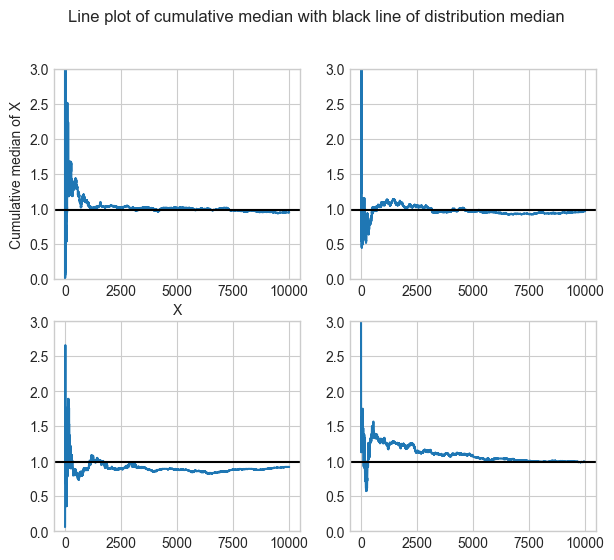

<Figure size 640x480 with 0 Axes>

In [35]:
# 12.7 Cumulative median of X
cum_median1 = np.array([])
for i in range(1, N+1):
    val = data1[0:i]
    cum_median1 = np.append(cum_median1, np.median(val))
print(cum_median1)

cum_median2 = np.array([])
for i in range(1, N+1):
    val = data2[0:i]
    cum_median2 = np.append(cum_median2, np.median(val))
print(cum_median2)

cum_median3 = np.array([])
for i in range(1, N+1):
    val = data3[0:i]
    cum_median3 = np.append(cum_median3, np.median(val))
print(cum_median3)

cum_median4 = np.array([])
for i in range(1, N+1):
    val = data4[0:i]
    cum_median4 = np.append(cum_median4, np.median(val))
print(cum_median4)


# 12.8 Plot of cumulative median and horizontal line of distribution median
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7,6))
fig.suptitle('Line plot of cumulative median with black line of distribution median')

axs[0,0].plot(range(N), cum_median1)
axs[0,0].axhline(median, c = 'black')
axs[0,0].set_ylim(0,3)
axs[0,0].set_ylabel('Cumulative median of X')
axs[0,0].set_xlabel('X')
#axs[0,0].set_title('Data 1')

axs[0,1].plot(range(N), cum_median2)
axs[0,1].axhline(median, c = 'black')
axs[0,1].set_ylim(0,3)
#axs[0,1].set_title('Data 2')

axs[1,0].plot(range(N), cum_median3)
axs[1,0].axhline(median, c = 'black')
axs[1,0].set_ylim(0,3)
#axs[1,0].set_title('Data 3')

axs[1,1].plot(range(N), cum_median4)
axs[1,1].axhline(median, c = 'black')
axs[1,1].set_ylim(0,3)
#axs[1,1].set_title('Data 4')

plt.show()

# Save the plot as a PNG file
plt.savefig('cumulative_median.png')

In [36]:
# 13 Code to load pickle with paper dataset from file SemanticScholarAPI
# Collecting the citations of papers from 2009:
#with open("finalPaperDf","rb") as fp:
#    papers = pickle.load(fp)

#%store -r finalPaperDf

papers = data.paperdf

year = papers.loc[papers['year'] == 2009]
citcount = year.loc[:,'citationCount']
citcount = citcount.to_numpy()

# Computing mean and median
mean = np.mean(citcount)
median = np.median(citcount)
print(mean, median)

# Extracting a random sample of 10.000 papers using mean and median calculated above
N = 10000
# Sampling 4 random samples from distribution
sample1 = np.random.choice(citcount, size=N)
sample2 = np.random.choice(citcount, size=N)
sample3 = np.random.choice(citcount, size=N)
sample4 = np.random.choice(citcount, size=N)

9.794952681388013 0.0


Text(0.5, 0.98, 'Distribution of X')

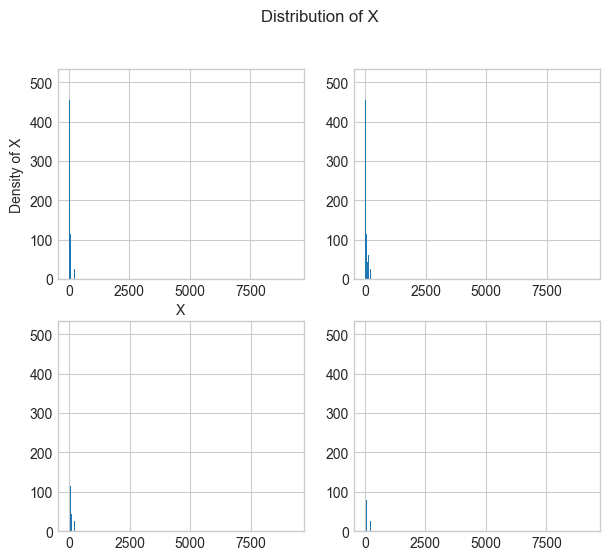

In [37]:
# 14.2 Plotting distribution of random sampled data
fig, ax = plt.subplots(2,2, figsize=(7,6))

# sample 1
bins1 = np.linspace(min(sample1), max(sample1), 30)
hist1, edges1 = np.histogram(sample1, bins=bins1)
x1 = (edges1[1:]+edges1[:-1])/2
#xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width1 = bins1[1]-bins1[0]

# sample 2
bins2 = np.linspace(min(sample2), max(sample2), 30)
hist2, edges2 = np.histogram(sample2, bins=bins2)
x2 = (edges2[1:]+edges2[:-1])/2
#xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width2 = bins2[1]-bins2[0]

# sample 3
bins3 = np.linspace(min(sample3), max(sample3), 30)
hist3, edges3 = np.histogram(sample3, bins=bins3)
x3 = (edges3[1:]+edges3[:-1])/2
#xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width3 = bins3[1]-bins3[0]

# sample 4
bins4 = np.linspace(min(sample4), max(sample4), 30)
hist4, edges4 = np.histogram(sample4, bins=bins4)
x4 = (edges4[1:]+edges4[:-1])/2
#xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width4 = bins4[1]-bins4[0]

ax[0,0].bar(hist1, x1, width1)
ax[0,0].set_ylabel('Density of X')
ax[0,0].set_xlabel('X')

ax[1,0].bar(hist2, x2, width2)
ax[0,1].bar(hist3, x3, width3)
ax[1,1].bar(hist4, x4, width4)

fig.suptitle('Distribution of X')

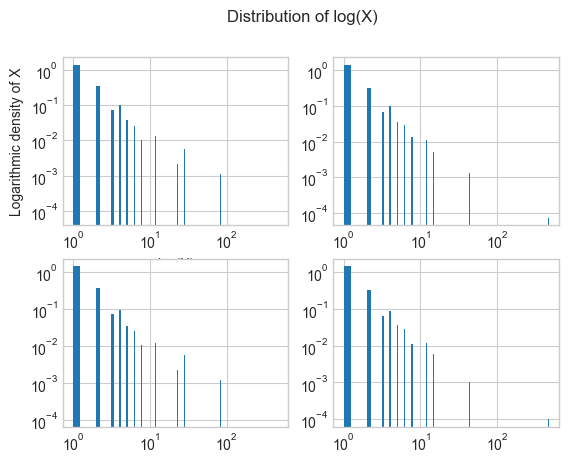

In [38]:

# 14.2 Plotting distribution of random sampled data (logarithmic)
fig, ax = plt.subplots(2,2)
# sample 1
bins = np.logspace(min(sample1), np.log10(max(sample1)), 30)
hist, edges = np.histogram(sample1, bins=bins, density=True)
x = (edges[1:]+edges[:-1])/2
xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]

# sample 2
bins2 = np.logspace(min(sample2), np.log10(max(sample2)), 30)
hist2, edges2 = np.histogram(sample2, bins=bins2, density=True)
x2 = (edges2[1:]+edges2[:-1])/2
xx2, yy2 = zip(*[(i,j) for (i,j) in zip(x2, hist2) if j>0])
width2 = bins2[1]-bins2[0]

# sample 3
bins3 = np.logspace(min(sample3), np.log10(max(sample3)), 30)
hist3, edges3 = np.histogram(sample3, bins=bins3, density=True)
x3 = (edges3[1:]+edges3[:-1])/2
xx3, yy3 = zip(*[(i,j) for (i,j) in zip(x3, hist3) if j>0])
width3 = bins3[1]-bins3[0]

# sample 4
bins4 = np.logspace(min(sample4), np.log10(max(sample4)), 30)
hist4, edges4 = np.histogram(sample4, bins=bins4, density=True)
x4 = (edges4[1:]+edges4[:-1])/2
xx4, yy4 = zip(*[(i,j) for (i,j) in zip(x4, hist4) if j>0])
width4 = bins4[1]-bins4[0]

ax[0,0].bar(xx, yy, width)
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Logarithmic density of X')
ax[0,0].set_xlabel('log(X)')

ax[1,0].bar(xx2, yy2, width2)
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')

ax[0,1].bar(xx3, yy3, width3)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')

ax[1,1].bar(xx4, yy4, width4)
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
fig.suptitle('Distribution of log(X)')
# Save the plot as a PNG file
plt.savefig('sample_distribution.png')

In [48]:


#14.3-14.5 Computing cumulative average of X,  cumulative std of X, distribution mean and median
cum_av1,cum_std1,mean1,median1 = cumAvg(sample1)
cum_av2,cum_std2,mean2,median2 = cumAvg(sample2)
cum_av3,cum_std3,mean3,median3 = cumAvg(sample3)
cum_av4,cum_std4,mean4,median4 = cumAvg(sample4)


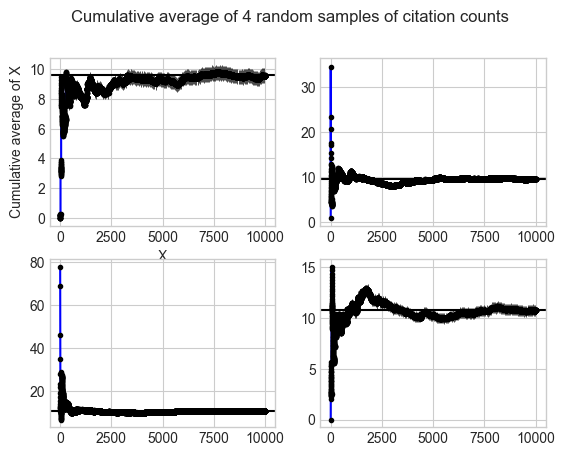

In [49]:

# 14.6 Plot of cumulative average as line plot with error bars and horizontal line of distribution mean
fig, ax = plt.subplots(2,2)

ax[0,0].plot(range(N), cum_av1, c = 'blue')
ax[0,0].errorbar(range(N), cum_av1, yerr = cum_std1, fmt='.k', errorevery=(1,50), elinewidth=0.5)
ax[0,0].axhline(mean1, c = 'black')
ax[0,0].set_ylabel('Cumulative average of X')
ax[0,0].set_xlabel('X')

ax[1,0].plot(range(N), cum_av2, c = 'blue')
ax[1,0].errorbar(range(N), cum_av2, yerr = cum_std2, fmt='.k', errorevery=(1,50), elinewidth=0.5)
ax[1,0].axhline(mean2, c = 'black')

ax[0,1].plot(range(N), cum_av3, c = 'blue')
ax[0,1].errorbar(range(N), cum_av3, yerr = cum_std3, fmt='.k', errorevery=(1,50), elinewidth=0.5)
ax[0,1].axhline(mean3, c = 'black')

ax[1,1].plot(range(N), cum_av4, c = 'blue')
ax[1,1].errorbar(range(N), cum_av4, yerr = cum_std4, fmt='.k', errorevery=(1,50), elinewidth=0.5)
ax[1,1].axhline(mean4, c = 'black')
fig.suptitle('Cumulative average of 4 random samples of citation counts')

# Save the plot as a PNG file
plt.savefig('cumulative_average.png')

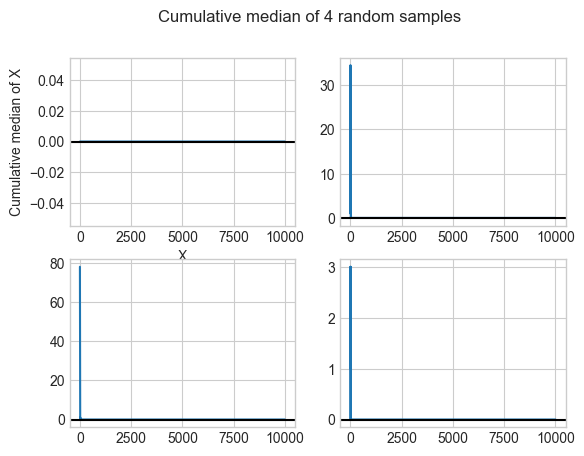

In [50]:

# 14.7 Cumulative median of X
cum_median1 = np.array([])
for i in range(1, N+1):
    val = sample1[0:i]
    cum_median1 = np.append(cum_median1, np.median(val))

cum_median2 = np.array([])
for i in range(1, N+1):
    val = sample2[0:i]
    cum_median2 = np.append(cum_median2, np.median(val))

cum_median3 = np.array([])
for i in range(1, N+1):
    val = sample3[0:i]
    cum_median3 = np.append(cum_median3, np.median(val))

cum_median4 = np.array([])
for i in range(1, N+1):
    val = sample4[0:i]
    cum_median4 = np.append(cum_median4, np.median(val))

# 14.8 Plot of cumulative median and horizontal line of distribution median
fig, ax = plt.subplots(2,2)

ax[0,0].plot(range(N), cum_median1)
ax[0,0].axhline(median1, c = 'black')
ax[0,0].set_xlabel('X')
ax[0,0].set_ylabel('Cumulative median of X')

ax[1,0].plot(range(N), cum_median2)
ax[1,0].axhline(median2, c = 'black')

ax[0,1].plot(range(N), cum_median3)
ax[0,1].axhline(median3, c = 'black')

ax[1,1].plot(range(N), cum_median4)
ax[1,1].axhline(median4, c = 'black')
fig.suptitle('Cumulative median of 4 random samples')

# Save the plot as a PNG file
plt.savefig('cumulative_median.png')

<font color="orange">The plots above have been run with few data points. Notebook can't handle our large pickle with all the papers. Therefore we have run the plot scripts with 7,463,239 papers in a normal python script and load the images here:

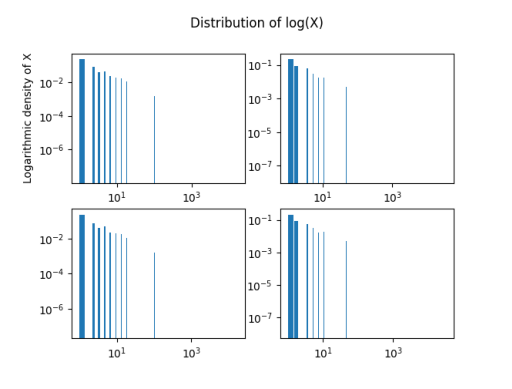

In [ ]:
img1 = img.imread("sample_distribution_full.png")
plt.grid(visible=None)
plt.axis('off')
plt.imshow(img1)
plt.show()

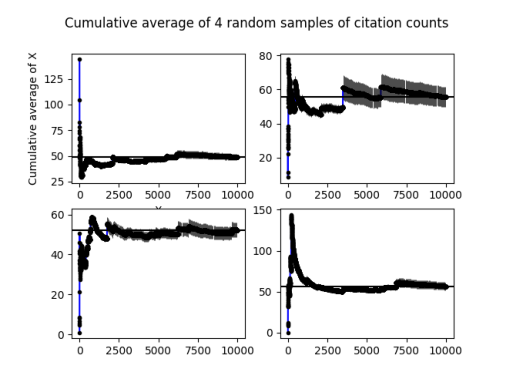

In [ ]:
img2 = img.imread("cumulative_average_full.png")
plt.grid(visible=None)
plt.axis('off')
plt.imshow(img2)
plt.show()

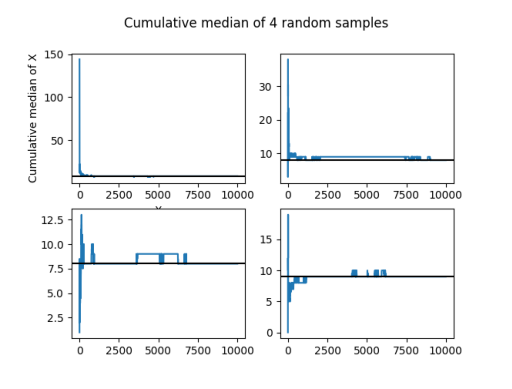

In [ ]:
img3 = img.imread("cumulative_median_full.png")
plt.grid(visible=None)
plt.axis('off')
plt.imshow(img3)
plt.show()

**Compare the evolution of the cumulative average for the Gaussian, Pareto and LogNormal distribution. What do you observe? Would you expect these results? Why?**

The cumulative average for the Gaussian distribution converges in some sense to the true median after calculating the cumulative average of 1/3 sample points. At this point, while taking the standard error of each point into consideration, it is approximately equal to the true median (shown as the red line on the plot). 

The cumulative average for the Pareto distribution holds large standard deviations as the value of cumulative average jumps from a very small number (approximately 0) to above 100.000. Afterwards when including more and more samples in the cumulative average is slowly converges to the true average, but if considering the standard errors it holds the value of the true average after 4000 samples.

The cumulative average for the LogNormal distribution has some trouble finding the true average, as the function values of X in the sample takes very different values in the range from 0 to 1700. Every time a very different function value is included in cumulative average, the model becomes more uncertain in finding the true average. Therefore it deviates from the true number until the sample holds approximately 8000 of the total number of samples.

**Compare the cumulative median vs the cumulative average for the three distributions. What do you observe? Can you draw any conclusions regarding which statistics (the mean or the median) is more usfeul in the different cases?**

For the Gaussian distributions, the cumulative median and cumulative average looks very similar and seems to have the same deviations at the specific number of sample point considered. In this case both statistics are useful for understanding the data.

The cumulative median and cumulative mean are very different for the Pareto distribution. The cumulative median is way better at finding the true median, as is considering the sorted list of samples thereby the function values of X grows as more samples are considering and the median is only calculated using the middle value/values of the list. At the same time the cumulative average has a hard time converging to the true mean, coming from the fast that is has approximately 2000 function values way above the rest of the values (as the distribution of the data is heavy tailed).

The LogNormal distribution data is exactly the same situation as the Pareto distribution, as they are both heavy tailed distributions. Therefore the data os also log-scaled. In these cases the median is more informative than the mean as it isn’t affected by outliers which affect the mean very much (as well as the standard deviation of the mean).

**Consider the plots you made using the citation count data in point 14. What do you observe? What are the implications?**

Plotting a histogram of the data it is clear that the data is very right skewed as the tail is present to the right. Therefore the data is log-transformed to account for the heavy tail.

**What do you think are the main take-home message of this exercise?**

The take-home message of this exercise is how to use summary statistics in order to capture properties of a dataset. Then it is possible to learn about the data by looking at for instance the density distribution of data points, for instance by finding that the data is heavy tailed or so.
